In [1]:
import os 
import random 

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Set reprodicibility

seed = 41

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

## Dataset loading

In [4]:
from utils.dataset_loader import load_datasets

(texts_train, labels_train), (texts_val, labels_val), (texts_test, labels_test) = load_datasets(folder_path='dataset', 
                                                                                                divide_by_sentence=True)


Vectorizing the texts

In [5]:
from tensorflow.keras.layers import TextVectorization

texts = texts_train + texts_val + texts_test

sequence_length = 50

vectorizer = TextVectorization(output_sequence_length=sequence_length, standardize=None)  

vectorizer.adapt(data=texts)

x = vectorizer(texts)

# Map from integers to word types
vocabulary = np.array(vectorizer.get_vocabulary())

x_train = x[:len(texts_train)]
x_val = x[len(texts_train):len(texts_train)+len(texts_val)]
x_test = x[len(texts_train)+len(texts_val):]

Vectorizing the labels

In [6]:
from tensorflow.keras.layers import TextVectorization

labels = labels_train + labels_val + labels_test

sequence_length = 50

vectorizer_labels = TextVectorization(output_sequence_length=sequence_length, standardize=None) 

vectorizer_labels.adapt(data=labels)

y = vectorizer_labels(labels)

# Map from integers to POS tags
vocabulary_labels = np.array(vectorizer_labels.get_vocabulary())

y_train = y[:len(labels_train)]
y_val = y[len(labels_train):len(labels_train)+len(labels_val)]
y_test = y[len(labels_train)+len(labels_val):]

n_classes = len(vocabulary_labels)

# The punctuation POS tags
punctuation_tags = [',', '.', ':', '``', "''"]
# The integers corresponding to the punctuation POS tags
punctuation_integers = [i for i,pos_tag in enumerate(vocabulary_labels) if pos_tag in punctuation_tags]

Glove embeddings

In [7]:
from utils.glove_loader import load_glove

embedding_dimension = 50

GLOVE_embeddings = load_glove(folder_path='glove_pretrained', embedding_dim=embedding_dimension)

Embedding matrix

In [8]:
from utils.embedding_matrix_builder import build_embedding_matrix

embedding_matrix = build_embedding_matrix(vocabulary=vocabulary, GLOVE_embeddings=GLOVE_embeddings, embedding_dimension=embedding_dimension)

Early stopping callback

In [9]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                            patience=3,
                                            min_delta=1e-3,
                                            restore_best_weights=True)

## Baseline Model

In [10]:
from models.baseline_model import build_baseline_model

baseline_model = build_baseline_model(n_classes=n_classes, embedding_matrix=embedding_matrix)

In [11]:
baseline_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 50)          547450    
                                                                 
 bidirectional (Bidirectiona  [(None, None, 256),      183296    
 l)                           (None, 128),                       
                              (None, 128),                       
                              (None, 128),                       
                              (None, 128)]                       
                                                                 
 dense (Dense)               (None, None, 47)          12079     
                                                                 
Total params: 742,825
Trainable params: 742,825
Non-trainable

In [12]:
baseline_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', 
                       metrics=['accuracy'])

In [13]:
baseline_model_history = baseline_model.fit(x=x_train, y=y_train, batch_size=32, epochs=50, validation_data=(x_val, y_val),
                                            callbacks=[callback])

Epoch 1/50
62/62 [==============================] - 13s 113ms/step - loss: 2.5923 - accuracy: 0.3241 - val_loss: 1.8711 - val_accuracy: 0.5224
Epoch 2/50
62/62 [==============================] - 5s 78ms/step - loss: 1.3466 - accuracy: 0.6611 - val_loss: 1.0225 - val_accuracy: 0.7429
Epoch 3/50
62/62 [==============================] - 5s 79ms/step - loss: 0.7764 - accuracy: 0.8054 - val_loss: 0.6977 - val_accuracy: 0.8191
Epoch 4/50
62/62 [==============================] - 5s 81ms/step - loss: 0.5336 - accuracy: 0.8630 - val_loss: 0.5462 - val_accuracy: 0.8537
Epoch 5/50
62/62 [==============================] - 5s 78ms/step - loss: 0.4049 - accuracy: 0.8961 - val_loss: 0.4592 - val_accuracy: 0.8740
Epoch 6/50
62/62 [==============================] - 5s 77ms/step - loss: 0.3215 - accuracy: 0.9167 - val_loss: 0.4096 - val_accuracy: 0.8851
Epoch 7/50
62/62 [==============================] - 5s 77ms/step - loss: 0.2633 - accuracy: 0.9317 - val_loss: 0.3745 - val_accuracy: 0.8939
Epoch 8/50


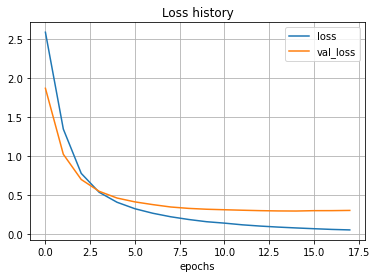

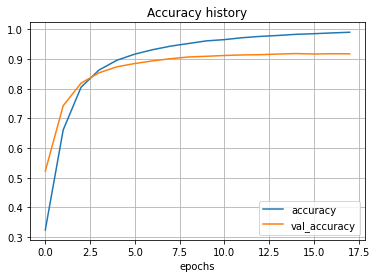

In [14]:
from utils.evaluate import plot_history

plot_history(baseline_model_history)

### Check the predicted labels on a single test sentence

In [15]:
print('Sentence:', texts_test[0])

Sentence: intelogic trace inc. , san antonio , texas , said it bought 2.7 million shares , or about 18 % , of its common stock from an unaffiliated shareholder for $ 3.625 a share , or $ 9.9 million .


In [16]:
print('True POS tags:', labels_test[0])

True POS tags: NNP NNP NNP , NNP NNP , NNP , VBD PRP VBD CD CD NNS , CC IN CD NN , IN PRP$ JJ NN IN DT JJ NN IN $ CD DT NN , CC $ CD CD .


In [17]:
print('Predicted POS tags:', vocabulary_labels[np.argmax(baseline_model(x_test[0:1]), axis=2)][0][:len(labels_test[0].split())])

Predicted POS tags: ['NNP' 'NNP' 'NNP' ',' 'NNP' 'NNP' ',' 'NNP' ',' 'VBD' 'PRP' 'VBD' 'CD'
 'CD' 'NNS' ',' 'CC' 'RB' 'CD' 'NN' ',' 'IN' 'PRP$' 'JJ' 'NN' 'IN' 'DT'
 'JJ' 'NN' 'IN' '$' 'CD' 'DT' 'NN' ',' 'CC' '$' 'CD' 'CD' '.']


### Test score

In [18]:
baseline_model.evaluate(x_test, y_test)

20/20 [==============================] - 0s 15ms/step - loss: 0.2723 - accuracy: 0.9216


[0.2722839415073395, 0.9216345548629761]

### F1 macro (no punctuation)

In [19]:
# Validation

from utils.evaluate import f1_macro

y_pred_val = np.argmax(baseline_model(x_val), axis=2)

f1_macro(y_true=y_val, y_pred=y_pred_val, punctuation_integers=punctuation_integers)

0.6913414797083668

In [20]:
# Test

from utils.evaluate import f1_macro

y_pred_test = np.argmax(baseline_model(x_test), axis=2)

f1_macro(y_true=y_test, y_pred=y_pred_test, punctuation_integers=punctuation_integers)

0.7850556344583299

## First Model

In [21]:
from models.first_model import build_first_model

first_model = build_first_model(n_classes=n_classes, embedding_matrix=embedding_matrix)

In [22]:
first_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 50)          547450    
                                                                 
 bidirectional_1 (Bidirectio  [(None, None, 256),      138240    
 nal)                         (None, 128),                       
                              (None, 128)]                       
                                                                 
 dense_1 (Dense)             (None, None, 47)          12079     
                                                                 
Total params: 697,769
Trainable params: 697,769
Non-trainable params: 0
_________________________________________________________________


In [23]:
first_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

In [24]:
first_model_history = first_model.fit(x=x_train, y=y_train, batch_size=32, epochs=20, validation_data=(x_val, y_val),
                                      callbacks=[callback])

Epoch 1/20
62/62 [==============================] - 15s 106ms/step - loss: 2.3044 - accuracy: 0.4171 - val_loss: 1.4157 - val_accuracy: 0.6511
Epoch 2/20
62/62 [==============================] - 4s 68ms/step - loss: 0.9862 - accuracy: 0.7516 - val_loss: 0.7734 - val_accuracy: 0.7949
Epoch 3/20
62/62 [==============================] - 4s 67ms/step - loss: 0.5831 - accuracy: 0.8476 - val_loss: 0.5545 - val_accuracy: 0.8472
Epoch 4/20
62/62 [==============================] - 4s 68ms/step - loss: 0.4166 - accuracy: 0.8886 - val_loss: 0.4577 - val_accuracy: 0.8720
Epoch 5/20
62/62 [==============================] - 4s 66ms/step - loss: 0.3234 - accuracy: 0.9143 - val_loss: 0.3970 - val_accuracy: 0.8879
Epoch 6/20
62/62 [==============================] - 4s 69ms/step - loss: 0.2588 - accuracy: 0.9316 - val_loss: 0.3595 - val_accuracy: 0.8955
Epoch 7/20
62/62 [==============================] - 4s 69ms/step - loss: 0.2124 - accuracy: 0.9439 - val_loss: 0.3302 - val_accuracy: 0.9035
Epoch 8/20


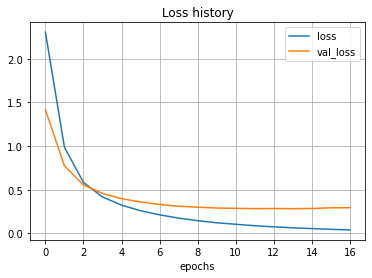

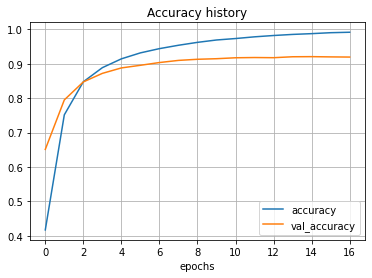

In [25]:
from utils.evaluate import plot_history

plot_history(first_model_history)

### Check the predicted labels on a single test sentence

In [26]:
print('Sentence:', texts_test[0])

Sentence: intelogic trace inc. , san antonio , texas , said it bought 2.7 million shares , or about 18 % , of its common stock from an unaffiliated shareholder for $ 3.625 a share , or $ 9.9 million .


In [27]:
print('True POS tags:', labels_test[0])

True POS tags: NNP NNP NNP , NNP NNP , NNP , VBD PRP VBD CD CD NNS , CC IN CD NN , IN PRP$ JJ NN IN DT JJ NN IN $ CD DT NN , CC $ CD CD .


In [28]:
print('Predicted POS tags:', vocabulary_labels[np.argmax(first_model(x_test[0:1]), axis=2)][0][:len(labels_test[0].split())])

Predicted POS tags: ['NNP' 'NNP' 'NNP' ',' 'NNP' 'NNP' ',' 'NNP' ',' 'VBD' 'PRP' 'VBD' 'CD'
 'CD' 'NNS' ',' 'CC' 'RB' 'CD' 'NN' ',' 'IN' 'PRP$' 'JJ' 'NN' 'IN' 'DT'
 'JJ' 'NN' 'IN' '$' 'CD' 'DT' 'NN' ',' 'CC' '$' 'CD' 'CD' '.']


### Test score

In [29]:
first_model.evaluate(x_test, y_test)

20/20 [==============================] - 0s 12ms/step - loss: 0.2635 - accuracy: 0.9233


[0.2634931206703186, 0.9232509732246399]

### F1 macro (no punctuation)

In [30]:
# Validation

from utils.evaluate import f1_macro

y_pred_val = np.argmax(first_model(x_val), axis=2)

f1_macro(y_true=y_val, y_pred=y_pred_val, punctuation_integers=punctuation_integers)

0.7000354892810248

In [31]:
# Test

from utils.evaluate import f1_macro

y_pred_test = np.argmax(first_model(x_test), axis=2)

f1_macro(y_true=y_test, y_pred=y_pred_test, punctuation_integers=punctuation_integers)

0.7931295135910058

## Second Model

In [32]:
from models.second_model import build_second_model

second_model = build_second_model(n_classes=n_classes, embedding_matrix=embedding_matrix)

In [33]:
second_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 50)          547450    
                                                                 
 bidirectional_2 (Bidirectio  [(None, None, 256),      183296    
 nal)                         (None, 128),                       
                              (None, 128),                       
                              (None, 128),                       
                              (None, 128)]                       
                                                                 
 bidirectional_3 (Bidirectio  [(None, None, 256),      394240    
 nal)                         (None, 128),                       
                              (None, 128),                 

In [34]:
import tensorflow as tf

second_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

In [35]:
second_model_history = second_model.fit(x=x_train, y=y_train, batch_size=32, epochs=20, validation_data=(x_val, y_val),
                                        callbacks=[callback])

Epoch 1/20
62/62 [==============================] - 31s 272ms/step - loss: 2.6200 - accuracy: 0.2722 - val_loss: 1.9098 - val_accuracy: 0.4892
Epoch 2/20
62/62 [==============================] - 11s 183ms/step - loss: 1.2868 - accuracy: 0.6607 - val_loss: 0.9351 - val_accuracy: 0.7463
Epoch 3/20
62/62 [==============================] - 11s 182ms/step - loss: 0.6980 - accuracy: 0.8168 - val_loss: 0.6232 - val_accuracy: 0.8296
Epoch 4/20
62/62 [==============================] - 11s 184ms/step - loss: 0.4727 - accuracy: 0.8737 - val_loss: 0.4953 - val_accuracy: 0.8621
Epoch 5/20
62/62 [==============================] - 11s 186ms/step - loss: 0.3596 - accuracy: 0.9043 - val_loss: 0.4291 - val_accuracy: 0.8771
Epoch 6/20
62/62 [==============================] - 11s 184ms/step - loss: 0.2815 - accuracy: 0.9250 - val_loss: 0.3792 - val_accuracy: 0.8888
Epoch 7/20
62/62 [==============================] - 12s 187ms/step - loss: 0.2243 - accuracy: 0.9408 - val_loss: 0.3469 - val_accuracy: 0.8997

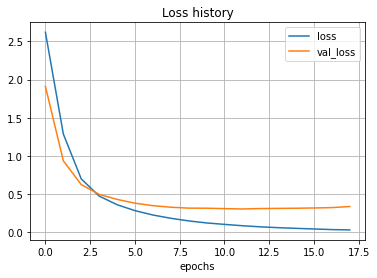

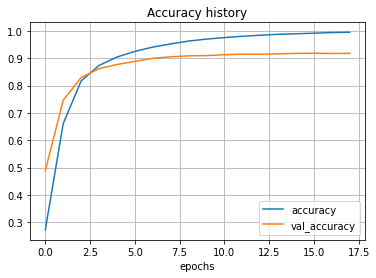

In [36]:
from utils.evaluate import plot_history

plot_history(second_model_history)

### Check the predicted labels on a single test sentence

In [39]:
print('Sentence:', texts_test[0])

Sentence: intelogic trace inc. , san antonio , texas , said it bought 2.7 million shares , or about 18 % , of its common stock from an unaffiliated shareholder for $ 3.625 a share , or $ 9.9 million .


In [40]:
print('True POS tags:', labels_test[0])

True POS tags: NNP NNP NNP , NNP NNP , NNP , VBD PRP VBD CD CD NNS , CC IN CD NN , IN PRP$ JJ NN IN DT JJ NN IN $ CD DT NN , CC $ CD CD .


In [41]:
print('Predicted POS tags:', vocabulary_labels[np.argmax(second_model(x_test[0:1]), axis=2)][0][:len(labels_test[0].split())])

Predicted POS tags: ['NNP' 'NNP' 'NNP' ',' 'NNP' 'NNP' ',' 'NNP' ',' 'VBD' 'PRP' 'VBD' 'CD'
 'CD' 'NNS' ',' 'CC' 'RB' 'CD' 'NN' ',' 'IN' 'PRP$' 'JJ' 'NN' 'IN' 'DT'
 'JJ' 'NN' 'IN' '$' 'CD' 'DT' 'NN' ',' 'CC' '$' 'CD' 'CD' '.']


### Test score

In [42]:
second_model.evaluate(x_test, y_test)

20/20 [==============================] - 1s 33ms/step - loss: 0.2804 - accuracy: 0.9234


[0.28037595748901367, 0.9233803153038025]

### F1 macro (no punctuation)

In [43]:
# Validation

from utils.evaluate import f1_macro

y_pred_val = np.argmax(second_model(x_val), axis=2)

f1_macro(y_true=y_val, y_pred=y_pred_val, punctuation_integers=punctuation_integers)

0.6580310823007425

In [44]:
# Test

from utils.evaluate import f1_macro

y_pred_test = np.argmax(second_model(x_test), axis=2)

f1_macro(y_true=y_test, y_pred=y_pred_test, punctuation_integers=punctuation_integers)

0.7918881138411897

## Third Model

In [45]:
from models.third_model import build_third_model

third_model = build_third_model(n_classes=n_classes, embedding_matrix=embedding_matrix)

In [46]:
third_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 50)          547450    
                                                                 
 bidirectional_4 (Bidirectio  [(None, None, 256),      183296    
 nal)                         (None, 128),                       
                              (None, 128),                       
                              (None, 128),                       
                              (None, 128)]                       
                                                                 
 dense_4 (Dense)             (None, None, 47)          12079     
                                                                 
Total params: 742,825
Trainable params: 742,825
Non-trainab

In [47]:
import tensorflow as tf

third_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

In [48]:
third_model_history = third_model.fit(x=x_train, y=y_train, batch_size=32, epochs=20, validation_data=(x_val, y_val),
                                      callbacks=[callback])

Epoch 1/20
62/62 [==============================] - 13s 110ms/step - loss: 2.6097 - accuracy: 0.3126 - val_loss: 1.8731 - val_accuracy: 0.5270
Epoch 2/20
62/62 [==============================] - 5s 79ms/step - loss: 1.3299 - accuracy: 0.6699 - val_loss: 0.9974 - val_accuracy: 0.7460
Epoch 3/20
62/62 [==============================] - 5s 77ms/step - loss: 0.7576 - accuracy: 0.8105 - val_loss: 0.6800 - val_accuracy: 0.8259
Epoch 4/20
62/62 [==============================] - 5s 77ms/step - loss: 0.5217 - accuracy: 0.8674 - val_loss: 0.5351 - val_accuracy: 0.8557
Epoch 5/20
62/62 [==============================] - 5s 81ms/step - loss: 0.3960 - accuracy: 0.8967 - val_loss: 0.4507 - val_accuracy: 0.8757
Epoch 6/20
62/62 [==============================] - 5s 82ms/step - loss: 0.3143 - accuracy: 0.9178 - val_loss: 0.4017 - val_accuracy: 0.8853
Epoch 7/20
62/62 [==============================] - 5s 82ms/step - loss: 0.2572 - accuracy: 0.9328 - val_loss: 0.3679 - val_accuracy: 0.8952
Epoch 8/20


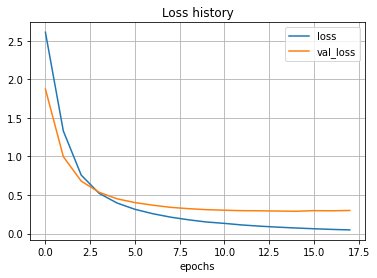

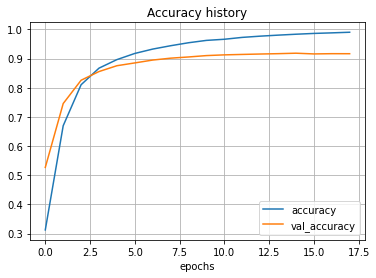

In [49]:
from utils.evaluate import plot_history

plot_history(third_model_history)

### Check the predicted labels on a single test sentence

In [50]:
print('Sentence:', texts_test[0])

Sentence: intelogic trace inc. , san antonio , texas , said it bought 2.7 million shares , or about 18 % , of its common stock from an unaffiliated shareholder for $ 3.625 a share , or $ 9.9 million .


In [51]:
print('True POS tags:', labels_test[0])

True POS tags: NNP NNP NNP , NNP NNP , NNP , VBD PRP VBD CD CD NNS , CC IN CD NN , IN PRP$ JJ NN IN DT JJ NN IN $ CD DT NN , CC $ CD CD .


In [52]:
print('Predicted POS tags:', vocabulary_labels[np.argmax(third_model(x_test[0:1]), axis=2)][0][:len(labels_test[0].split())])

Predicted POS tags: ['NNP' 'NNP' 'NNP' ',' 'NNP' 'NNP' ',' 'NNP' ',' 'VBD' 'PRP' 'VBD' 'CD'
 'CD' 'NNS' ',' 'CC' 'RB' 'CD' 'NN' ',' 'IN' 'PRP$' 'JJ' 'NN' 'IN' 'DT'
 'JJ' 'NN' 'IN' '$' 'CD' 'DT' 'NN' ',' 'CC' '$' 'CD' 'CD' '.']


### Test score

In [53]:
third_model.evaluate(x_test, y_test)

20/20 [==============================] - 0s 16ms/step - loss: 0.2766 - accuracy: 0.9212


[0.2766224443912506, 0.9211819767951965]

### F1 macro (no punctuation)

In [54]:
# Validation

from utils.evaluate import f1_macro

y_pred_val = np.argmax(third_model(x_val), axis=2)

f1_macro(y_true=y_val, y_pred=y_pred_val, punctuation_integers=punctuation_integers)

0.6750600184847289

In [55]:
# Test

from utils.evaluate import f1_macro

y_pred_test = np.argmax(third_model(x_test), axis=2)

f1_macro(y_true=y_test, y_pred=y_pred_test, punctuation_integers=punctuation_integers)

0.7875452368303134